In [43]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas import Series
from matplotlib import pyplot
import datetime
import glob
import numpy as np
from io import StringIO
import io
import re

### Before you begin the cleaning process on Jupyter, you have to make sure:
1. Your Siteno for both Water Level and Site datat sets are consistent in type "text" in excel, so that they can merge accurately.
2. Make sure you have all files in the same folder.
3. Make sure all files have the same number of columns.

### About this Data Preparation Notebook
The goal is to combine all datasets from ACWI in an efficient and accurate manner. The way we collected the ACWI data is by setting a standard filter and download by area.
#### The main steps taken are as follows:
1. Group by Site ID and by Date - You want a observations by unique sites and you want as many *regular* observations - which is why we aggregate by month.
2. We retained corresponding well depth, coordinates and fips for each Site.
3. We calculate the row means and standard deviation for depth to water - for cluster analysis.
4. Reformat fips to be consistent with existing data.

### Step 1: Read all your files and concatenate into two separate data frames:
1. Site = site
2. Water levels = current

In [ ]:
os.getcwd()
dir=os.chdir('/Users/ainulrosli/Desktop/acwi/data z')
filelist1 = []
filelist2 = []
os.chdir('/Users/ainulrosli/Desktop/acwi/data z')
for counter, files in enumerate(glob.glob("*LEVEL*.csv")):
    filelist1.append(files)
    print(filelist1)

for fileitem in filelist1:
    print(fileitem)
    
for counter, files in enumerate(glob.glob("*INFO*.csv")):
    filelist2.append(files)
    print(filelist2)

for fileitem in filelist2:
    print(fileitem)

### Concantenate

In [ ]:
df_list1 = [pd.read_csv(file,dtype = {'SiteNo': str},error_bad_lines=False) for file in filelist1]
df_list2 = [pd.read_csv(file, dtype = {'SiteNo': str}) for file in filelist2]
#concatenate them, separately
current = pd.concat(df_list1)
site = pd.concat(df_list2)
for col in current.columns:
   print('columns', col,':', type(col[0]))

#### NB - Manual Sanity Check - Can delete once done

1. one = pd.read_csv('WATERLEVEL5.csv')
2. two = pd.read_csv('WATERLEVEL6.csv')
3. three = pd.read_csv('WATERLEVEL7.csv')
4. four = pd.read_csv('WATERLEVEL8.csv')
5. len(four) + len(one) + len(two) + len(three)
6. len(cur)

#### Let's see if the concantenation worked

In [47]:
current.head()
site.head()
current.shape

(3253296, 13)

### Step 2 : Remove the irrelevant columns for both Site and Water Level Data
#### We start with the water level data

In [48]:
cur = current.loc[:,['SiteNo', 'Time', 'Depth to Water Below Land Surface in ft.']]
cur.columns = ["Siteno", "Date", "Depth.to.Water"]
cur.head()

,Siteno,Date,Depth.to.Water
0,371252101084201,1999-01-06T12:11:00-06:00,182.92
1,371252101084201,2000-01-07T09:32:45-06:00,185.35
2,371252101084201,2001-01-06T09:49:28-06:00,191.79
3,371252101084201,2002-01-07T09:53:48-06:00,196.07
4,371252101084201,2003-01-09T16:10:15-06:00,207.05


In [ ]:
cur['Date'] = cur['Date'].apply(lambda x: x.split('T')[0])
cur[cur.Date.isnull()]
cur['Date'].dropna()

In [50]:
cur['Date'] = pd.to_datetime(cur['Date'], format='%Y-%m-%d', errors="coerce")

#### Checking data type for each column

In [51]:
for col in cur:
    print(type(cur[col][1]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
# not sure why plotting isn't working - will revisit
cur = cur.sort_values('Date', ascending=False)
plt.plot(cur['Date'], cur['Siteno'])
plt.hist(cur['Siteno'])
pyplot.show()

#### Now we clean Site data frame

In [54]:
site = site.loc[:,['SiteNo','DecLatVa', 'DecLongVa','WellDepth','LocalAquiferName', 'StateCd', 'StateNm', 'CountyCd', 'CountyNm']]
site.columns = ['Siteno','Lat', 'Lon','WellDepth','Aquifer', 'StateCd', 'StateNm', 'CountyCd', 'CountyNm']
site.head()

,Siteno,Lat,Lon,WellDepth,Aquifer,StateCd,StateNm,CountyCd,CountyNm
0,371252101084201,37.213770,-101.146940,542.0,Ogallala Formation,20.0,Kansas,189.0,Stevens County
1,371641101254101,37.278774,-101.428936,475.0,Ogallala Formation,20.0,Kansas,189.0,Stevens County
2,371713101125601,37.287044,-101.216537,460.0,Ogallala Formation,20.0,Kansas,189.0,Stevens County
3,371916101031901,37.322024,-101.056622,530.0,Ogallala-Dakota Formation,20.0,Kansas,175.0,Seward County
4,372214101211701,37.370003,-101.357540,514.0,Ogallala Formation,20.0,Kansas,189.0,Stevens County


### Creating a fips column - needs to be refined but works for now

In [55]:
site[['StateCd','CountyCd']]= site[['StateCd','CountyCd']].fillna(0).astype(int)
site['CountyCd'] = site['CountyCd'].apply(lambda x: str(int(x)).zfill(3))
site['fips'] = site[['StateCd','CountyCd']].astype(str).sum(axis=1)
site['fips'] = site[['fips']].astype(int)
site.head()

,Siteno,Lat,Lon,WellDepth,Aquifer,StateCd,StateNm,CountyCd,CountyNm,fips
0,371252101084201,37.213770,-101.146940,542.0,Ogallala Formation,20,Kansas,189,Stevens County,20189
1,371641101254101,37.278774,-101.428936,475.0,Ogallala Formation,20,Kansas,189,Stevens County,20189
2,371713101125601,37.287044,-101.216537,460.0,Ogallala Formation,20,Kansas,189,Stevens County,20189
3,371916101031901,37.322024,-101.056622,530.0,Ogallala-Dakota Formation,20,Kansas,175,Seward County,20175
4,372214101211701,37.370003,-101.357540,514.0,Ogallala Formation,20,Kansas,189,Stevens County,20189


### Step 3: Merge both Site and Water Level Data

In [56]:
ind = pd.merge(cur, site, how='inner', on=['Siteno'])
len(ind)
ind.head()

,Siteno,Date,Depth.to.Water,Lat,Lon,WellDepth,Aquifer,StateCd,StateNm,CountyCd,CountyNm,fips
0,475439116503401,2017-10-31,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
1,475439116503401,2017-10-31,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
2,475439116503401,2017-10-31,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
3,475439116503401,2017-10-31,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
4,475439116503401,2017-10-30,395.96,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055


#### Changing Date format to month and year only for ease of analysis

In [57]:
ind.Date = pd.to_datetime(ind.Date).dt.strftime('%Y-%m')

#### Check how many *current* well measurements are available 
There are almost 500 uniques sites with observations since 1930s, but how many of these sites have measurements in recent months/years?

In [ ]:
len(ind['Siteno'].unique())/len(ind.loc[mask1].Siteno.unique())

In [58]:
# checking unique numbers of Site No. 
print("no. of unique sites")
print(len(ind['Siteno'].unique()))

mask1 = (ind['Date'] > '2017-09') & (ind['Date'] <= '2017-10')
mask2 = (ind['Date'] > '2017-01') & (ind['Date'] <= '2017-10')
mask3 = (ind['Date'] > '2016-01') & (ind['Date'] <= '2017-10')
print("no. of unique current sites")
print("Oct 2017    " + str(int(len(ind.loc[mask1].Siteno.unique())/len(ind['Siteno'].unique())*100)), "%")
print(len(ind.loc[mask1].Siteno.unique()))
print("Jan-Oct 2017  " + str(int(len(ind.loc[mask2].Siteno.unique())/len(ind['Siteno'].unique())*100)), "%")
print(len(ind.loc[mask2].Siteno.unique()))
print("2016 - Oct 2017  " + str(int(len(ind.loc[mask3].Siteno.unique())/len(ind['Siteno'].unique())*100)),"%")
print(len(ind.loc[mask3].Siteno.unique()))

no. of unique sites
1554
no. of unique current sites
Oct 2017    14 %
227
Jan-Oct 2017  51 %
808
2016 - Oct 2017  76 %
1191


In [59]:
ind.head()

,Siteno,Date,Depth.to.Water,Lat,Lon,WellDepth,Aquifer,StateCd,StateNm,CountyCd,CountyNm,fips
0,475439116503401,2017-10,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
1,475439116503401,2017-10,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
2,475439116503401,2017-10,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
3,475439116503401,2017-10,395.99,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055
4,475439116503401,2017-10,395.96,47.91065,-116.843817,448.56,Outwash,16,Idaho,055,Kootenai County,16055


In [60]:
#  Data Sanity again - let's see if this is required - something was inconsistent with data type across dataset
ind['Depth.to.Water'] = ind['Depth.to.Water'].astype('float')

In [62]:
g = ind.groupby(['Siteno','Date'], as_index=False, sort=False)['Depth.to.Water', 'Lat', 'Lon','WellDepth', 'StateCd', 'StateNm', 'CountyCd', 'CountyNm','Aquifer'].mean()
g.sort_values(by='Date',inplace=True)
g.head()

,Siteno,Date,Depth.to.Water,Lat,Lon,WellDepth,StateCd
82872,423532088254601,1902-01,59.00,42.592453,-88.429728,820.0,55
71835,WASC0002425,1928-01,80.00,45.602794,-121.201660,210.0,41
98308,HARN0000547,1928-10,6.70,43.590675,-118.935745,93.0,41
98307,HARN0000547,1928-12,6.35,43.590675,-118.935745,93.0,41
98306,HARN0000547,1929-01,6.00,43.590675,-118.935745,93.0,41


In [63]:
f = g.pivot(index='Siteno', columns='Date', values='Depth.to.Water')
f.reset_index(inplace=True)
f.columns.name = ''

In [64]:
lon = ind.groupby(['Siteno'], as_index=False, sort=False)['Lon'].mean()
lat = ind.groupby(['Siteno'], as_index=False, sort=False)['Lat'].mean()
WellDepth = ind.groupby(['Siteno'], as_index=False, sort=False)['WellDepth'].mean()
fips = ind.groupby(['Siteno'], as_index=False, sort=False)['fips'].mean()
State = ind.groupby(['Siteno'], as_index=False, sort=False)['StateCd'].mean()
County = ind.groupby(['Siteno'], as_index=False, sort=False)['CountyCd'].mean()
f['lon'] = ind.groupby(['Siteno'], as_index=False, sort=False)['Depth.to.Water', 'DecLatVa', 'DecLongVa','WellDepth', 'StateCd', 'StateNm', 'CountyCd', 'CountyNm'].mean()
g['lon'] = g.set_index('Siteno')['WellDepth'].drop_duplicates()

In [170]:
df = pd.merge(f, lon, how='inner', on=['Siteno'])
df = pd.merge(df, lat, how='inner', on=['Siteno'])
df = pd.merge(df, WellDepth, how='inner', on=['Siteno'])
df = pd.merge(df, fips, how='inner', on=['Siteno'])
df.head()
df = pd.merge(df, State, how='inner', on=['Siteno'])
df = pd.merge(df, County, how='inner', on=['Siteno'])

,Siteno,1902-01,1928-01,1928-10,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,...,2017-06,2017-07,2017-08,2017-09,2017-10,NaT,Lon,Lat,WellDepth,fips
0,1002502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-102.816667,34.928611,328.0,48117
1,1002502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-102.816667,34.928611,328.0,48117
2,1004603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,258.88,-102.523611,34.925278,318.0,48117
3,1004603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,258.88,-102.523611,34.925278,318.0,48117
4,1004901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,227.085,227.425,227.788333,227.95,NaN,NaN,-102.527777,34.895555,321.0,48117


### Perform Row Means and Standard Deviation on all Water Table Values across time
1. We do this by identifying regex for the date columns (only date columns would numbers = months)
2. Select amd perform calculation on row axis 1

In [171]:
cols = df.filter(regex='01|02|03|04|05|06|07|08|09|10|11|12').columns
cols = list(cols)
df.replace(to_replace=999999, value=0, inplace=True) ## This is to replaxe any 999999 with NaN
df['mean'] = df.loc[:,cols].mean(axis=1) 
df['sd'] = df.loc[:,cols].std(axis=1)
# To check if any row value = 9999999, which basically is NaN
#df[(df.values[None, :] == np.array([999999])[:, None, None]).any(0).any(1)]

In [149]:
df.head()

,Siteno,1902-01,1928-01,1928-10,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,...,2017-08,2017-09,2017-10,NaT,Lon,Lat,WellDepth,fips,mean,sd
1070,452036093423701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-93.710944,45.343236,9.08,27141,4.516786,0.943817
754,413722087304101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.39,NaN,NaN,NaN,-87.511431,41.622813,9.10,18089,4.295280,0.952417
1009,443834092390301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.43,NaN,NaN,NaN,-92.651111,44.642778,10.99,27049,4.024545,1.485930
1008,443834000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.43,NaN,NaN,NaN,-92.651111,44.642778,10.99,27049,4.024545,1.485930
1007,443834000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.43,NaN,NaN,NaN,-92.651111,44.642778,10.99,27049,4.024545,1.485930


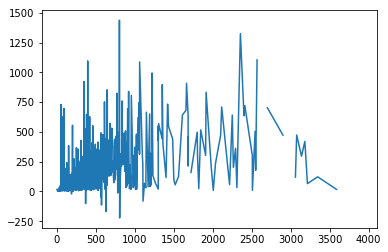

In [164]:
print(len(df))
df = df.sort_values('WellDepth', ascending=True)
plt.plot(df['WellDepth'], df['mean'])
pyplot.show()

In [172]:
x = df.query('mean > WellDepth').index
df = df.drop(df.index[[x]])
print(len(df))

1500


#### After removing wells where mean > well depth = which doesn't make sense 

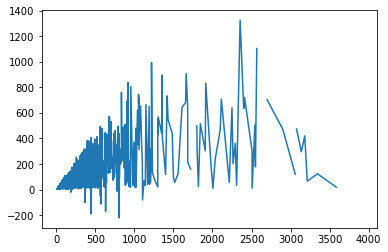

In [173]:
df = df.sort_values('WellDepth', ascending=True)
plt.plot(df['WellDepth'], df['mean'])
pyplot.show()

In [174]:
df.to_csv('acwi_1000.csv')